In [1]:
import gym
import numpy as np
import torch

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="bright")
%matplotlib inline

In [2]:
from envs import make_vec_envs
from a2c_ppo_acktr.algo.ppo import PPO
from a2c_ppo_acktr.model import Policy

In [3]:
from ppo_config import *
from curiosity import ForwardModel, InverseModel, ICM, RND, random_observations, CuriosityModule
from train import train_loop
from plot_utils import plot_stats, plot_stats_with_curiosity, plot_curiosity_history

In [4]:
env_name = "MountainCar-v0"
time_limit = gym.make(env_name).spec.tags['wrapper_config.TimeLimit.max_episode_steps']

num_env_steps = int(3e6)
num_updates = int(num_env_steps) // num_steps // num_processes
lr_decay_horizon = int(10e6) // num_steps // num_processes
log_interval = 10
eval_interval = 1
device = torch.device("cpu")

/Users/maria/thesis/sim_rl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
envs = make_vec_envs(env_name, 1,
                     num_processes,
                     gamma,
                     device, False, normalize_obs=False)

actor_critic = Policy(
    envs.observation_space.shape,
    envs.action_space,
    base_kwargs={'recurrent': False}).to(device)

agent = PPO(actor_critic,
            clip_param,
            ppo_epochs,
            num_mini_batch,
            value_loss_coef,
            entropy_coef,
            lr,
            eps,
            max_grad_norm)

Creating dummy env object to get spaces


In [11]:
rnd_module = RND(envs.observation_space.shape[0], envs.num_envs)
rnd_module.to(device)
rnd_module.init_obs_norm(random_observations(env_name, size=2000, device=device))

cur_coef = 10.
cur_lr = 1e-3

curiosity_module = CuriosityModule(rnd_module, cur_coef, curiosity_lr=cur_lr)

Updates 830, num timesteps 1701888, FPS 1401
Current lr: 0.00058


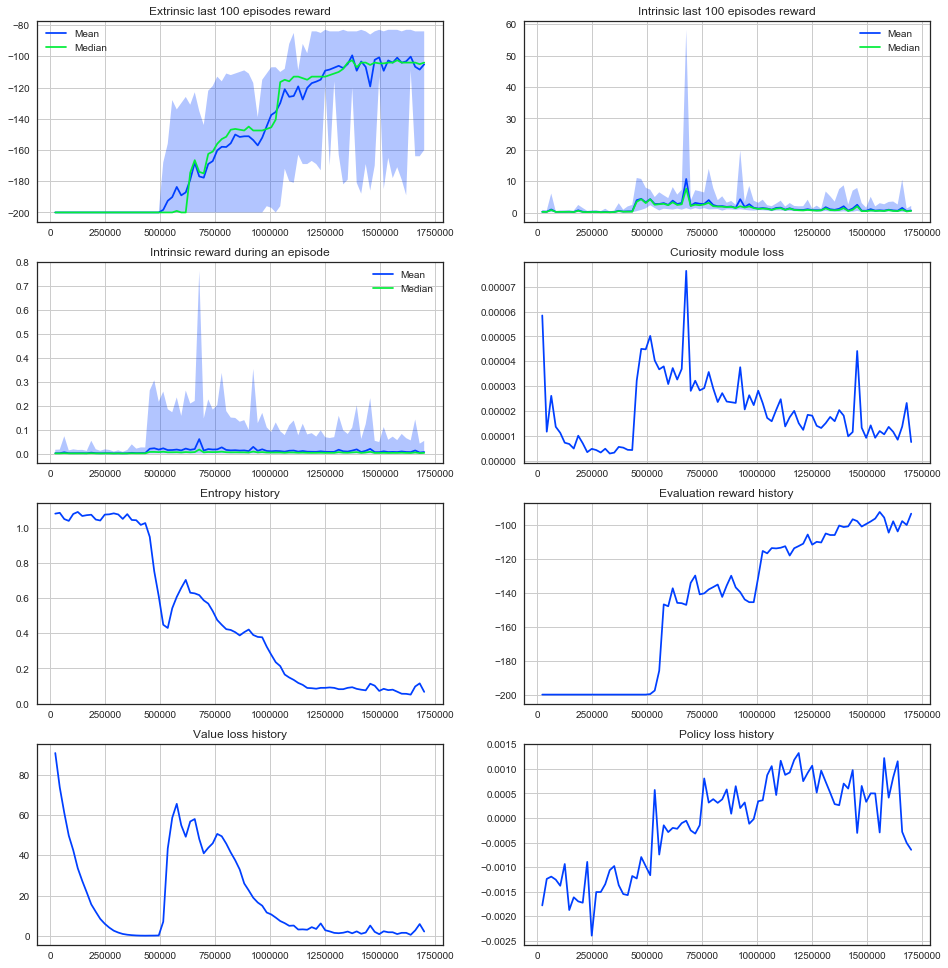

In [ ]:
stats = train_loop(agent, envs, env_name, num_updates, num_steps, curiosity_module=curiosity_module, 
           save_interval=save_interval, eval_interval=eval_interval, log_interval=log_interval,
           time_limit=time_limit, curiosity_rew_after=0, curiosity_rew_before=None,
           use_linear_lr_decay=True, lr_decay_horizon=lr_decay_horizon,
           callbacks=[plot_stats_with_curiosity])

In [ ]:
plot_curiosity_history('./pictures', 'example', stats, 'RND', env_name, num_processes, num_steps, save=False)